# Deep Convolutional GAN 실습

출처 : 모두의 딥러닝

링크 : https://thebook.io/080324/0306/

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape,Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_2 (Bat  (None, 6272)              25088     
 chNormalization)                                                
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)       

In [9]:

# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_4 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_5 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [10]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


In [ ]:
epoch = 5000
batch_size = 128
saving_interval = 500

# 이미지를 저장할 폴더가 없으면 생성
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

# MNIST 데이터 불러오기
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5  # 127.5를 뺀 후 127.5로 나누어서 -1~1 사이의 값으로 바꿉니다.

true = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for i in range(epoch):
    # 실제 데이터를 판별자에 입력하는 부분입니다.
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력하는 부분입니다.
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차를 계산합니다.
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

    # 이미지 저장 부분
    if i % saving_interval == 0:
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1

        fig, axs = plt.subplots(5, 5)
        count = 0
        for j in range(5):
            for k in range(5):
                axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[j, k].axis('off')
                count += 1
        fig.savefig("gan_images/gan_mnist_%d.png" % i)
        plt.close(fig)  # 메모리 누수 방지를 위해 plt 객체를 닫습니다.


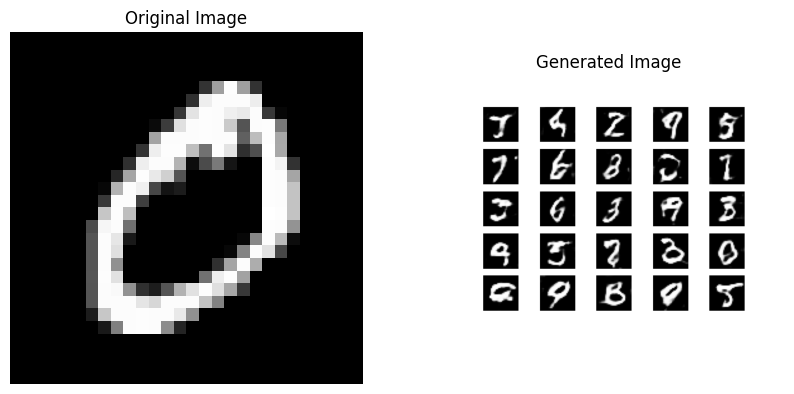

In [19]:
def load_and_compare_images(epoch, example_index=0):
    # MNIST 데이터 불러오기
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5  # Normalize

    # 저장된 이미지 불러오기
    image_path = f"gan_images/gan_mnist_{epoch}.png"
    if not os.path.exists(image_path):
        print("해당 경로에 이미지 파일이 없습니다:", image_path)
        return

    generated_image = mpimg.imread(image_path)

    # 원본 이미지 선택
    original_image = X_train[example_index].reshape(28, 28)

    # 이미지 비교
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(generated_image)
    axs[1].set_title('Generated Image')
    axs[1].axis('off')

    plt.show()

# 예를 들어, 200번째 에포크의 생성된 이미지와 원본 이미지 비교
load_and_compare_images(4000, example_index=1)
